In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
folder_path = '/content/drive/My Drive/FYP'
os.chdir(folder_path)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found


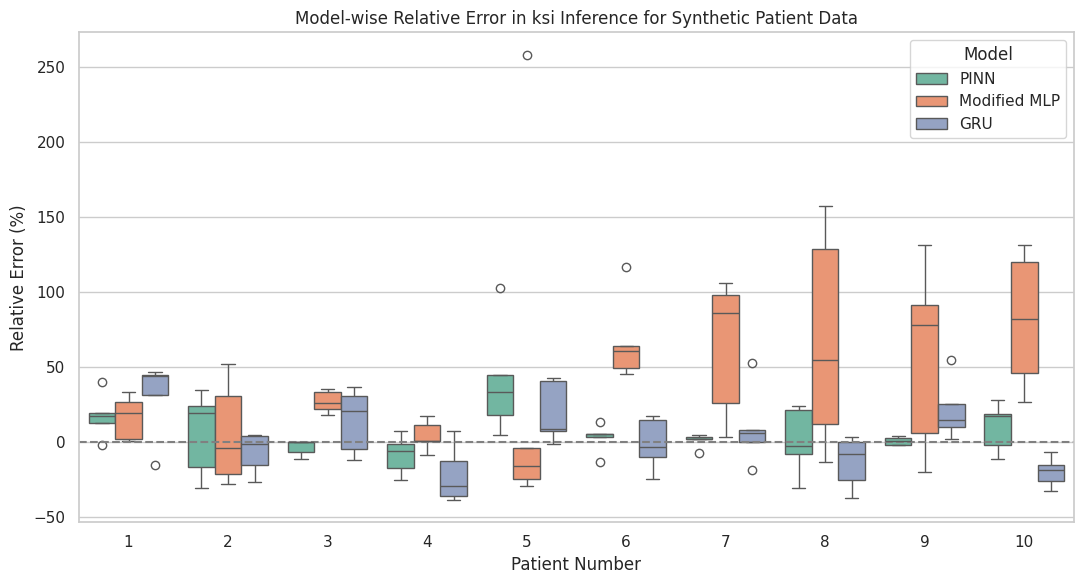

    Patient         Model    Mean_RE      Std_RE
0         1           GRU  30.154749   26.141920
1         1  Modified MLP  16.329949   14.672754
2         1          PINN  17.291371   15.245282
3         2           GRU  -6.964133   13.797254
4         2  Modified MLP   5.634307   34.418418
5         2          PINN   6.127007   28.116172
6         3           GRU   14.19553   21.362354
7         3  Modified MLP  26.811518    7.221149
8         3          PINN  -3.831414    5.191779
9         4           GRU -21.898698   19.194420
10        4  Modified MLP   4.277305   10.131505
11        4          PINN  -8.583688   12.888565
12        5           GRU  19.653451   20.611751
13        5  Modified MLP  36.731034  124.218206
14        5          PINN   40.64335   37.805775
15        6           GRU  -1.224817   17.476222
16        6  Modified MLP  67.092135   28.683439
17        6          PINN   2.705618    9.889405
18        7           GRU    9.41322   26.174213
19        7  Modifie

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Define Patient IDs and Ground Truth ===
patients = list(range(1, 11))
true_vals = [197, 274, 191, 282, 203, 267, 200, 272, 191, 282]
true_ksi_map = dict(zip(patients, true_vals))

# === Step 2: Manually Enter PINN and Mod MLP Predictions ===

pinn_ksi = [
    235.1, 192.48, 221.41, 275.89, 230.44,
    190.57, 228.15, 368.71, 326.41, 340.1,
    190.57, 169.02, 177.68, 190.57, 190.57,
    278.66, 265.07, 301.87, 232.76, 210.61,
    292.95, 212.72, 239.85, 411.58, 270.43,
    275.89, 230.44, 281.46, 281.46, 301.87,
    206.44, 184.93, 204.38, 208.51, 204.28,
    336.97, 265.07, 330.3, 188.67, 249.64,
    196.37, 192.48, 186.79, 186.79, 198.34,
    361.31, 330.3, 249.64, 275.89, 333.62
]

mlp_ksi = [
    235.1, 262.43, 249.64, 200.34, 198.34,
    357.81, 196.37, 415.72, 214.86, 262.43,
    239.95, 225.85, 232.76, 254.68, 257.81,
    257.24, 314.19, 330.3, 284.29, 284.29,
    194.3, 152.93, 142.59, 170.72, 727.28,
    437.03, 387.61, 428.38, 578.25, 399.41,
    411.58, 206.44, 252.14, 395.44, 372.41,
    304.9, 622.7, 419.89, 235.1, 699.24,
    340.36, 365.04, 202.35, 441.42, 152.93,
    411.58, 512.86, 357.81, 651.97, 620.17
]

expanded_patients = patients * 5
expanded_patients.sort()

pinn_df = pd.DataFrame({"Patient": expanded_patients, "KSI": pinn_ksi})
pinn_df["Model"] = "PINN"

mlp_df = pd.DataFrame({"Patient": expanded_patients, "KSI": mlp_ksi})
mlp_df["Model"] = "Modified MLP"

# === Step 3: Load GRU Data from File ===
# Replace the file path with your actual path
gru_df = pd.read_csv("gru_ksi_estimates_all_patients.csv")  # or .dat with sep="," or sep="\t"

# Convert to the same format as others
gru_df = gru_df.groupby("Patient")["Final_ksi"].apply(list).explode().reset_index()
gru_df["Model"] = "GRU"
gru_df.rename(columns={"Final_ksi": "KSI"}, inplace=True)
gru_df["Patient"] = gru_df["Patient"].astype(int) - 1

# === Step 4: Compute Relative Errors ===
def compute_rel_error(df):
    df = df.copy()
    df["True_KSI"] = df["Patient"].map(true_ksi_map)
    df["Rel_Error"] = (df["KSI"] - df["True_KSI"]) / df["True_KSI"] * 100
    return df[["Patient", "Model", "Rel_Error"]]

pinn_err = compute_rel_error(pinn_df)
mlp_err = compute_rel_error(mlp_df)
gru_err = compute_rel_error(gru_df)

rel_error_df = pd.concat([pinn_err, mlp_err, gru_err], ignore_index=True)

# === Step 5: Plot Relative Error ===
sns.set(style="whitegrid")
plt.figure(figsize=(11, 6))
sns.boxplot(data=rel_error_df, x="Patient", y="Rel_Error", hue="Model", palette="Set2")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Model-wise Relative Error in ksi Inference for Synthetic Patient Data")
plt.ylabel("Relative Error (%)")
plt.xlabel("Patient Number")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("InverseSynthetic.png", dpi=600, bbox_inches="tight")
plt.show()

# === Step 6: Compute Mean and Standard Deviation of RE per Patient and Model ===
summary_stats = (
    rel_error_df.groupby(["Patient", "Model"])["Rel_Error"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "Mean_RE", "std": "Std_RE"})
)

# Display results
print(summary_stats)


In [3]:
df = pd.read_csv("gru_ksi_estimates_all_patients.csv")
df["Rel_Deviation"] = (df["Final_ksi"] - df["Initial_ksi"]) / df["Initial_ksi"]

mean_rel_dev = df.groupby("Patient")["Rel_Deviation"].mean().reset_index()
mean_rel_dev["Rel_Deviation (%)"] = mean_rel_dev["Rel_Deviation"] * 100

print(mean_rel_dev)

   Patient  Rel_Deviation  Rel_Deviation (%)
0        2       0.004707           0.470714
1        3      -0.000422          -0.042218
2        4      -0.025742          -2.574177
3        5      -0.001063          -0.106324
4        6      -0.010672          -1.067184
5        7      -0.008062          -0.806161
6        8       0.006030           0.602994
7        9      -0.001789          -0.178921
8       10      -0.024520          -2.451952
9       11       0.006205           0.620498


<ipython-input-4-a027183a2bf2>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rel_error_df, x="Model", y="Rel_Error", palette="Set2")


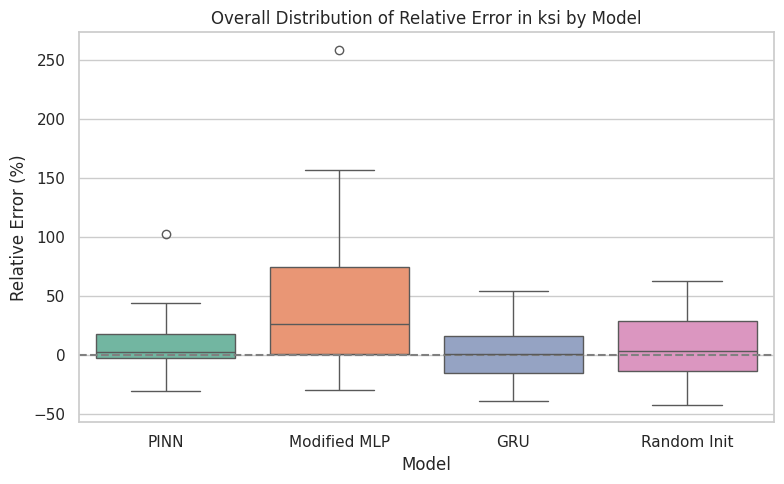


=== Overall Mean and Std of Relative Error per Model ===
          Model    Mean_RE     Std_RE
0           GRU   3.109408  25.147319
1  Modified MLP  42.690924  57.347638
2          PINN    6.65765  21.619417
3   Random Init   5.702556  29.188356


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === STEP 1: Generate Random Init Relative Errors ===
true_vals = np.array([197, 274, 191, 282, 203, 267, 200, 272, 191, 282])
n_runs = 5
true_vals_repeated = np.tile(true_vals, n_runs)

# Uniformly sample from [156.18, 315.62]
random_ksi = np.random.uniform(156.18, 315.62, size=true_vals_repeated.shape)

# Compute relative error
rel_error_random = 100 * (random_ksi - true_vals_repeated) / true_vals_repeated

# Create DataFrame
df_random = pd.DataFrame({
    "Model": "Random Init",
    "Rel_Error": rel_error_random
})

# === STEP 2: Append to existing rel_error_df ===
# You must already have this from your models: rel_error_df with "Model" and "Rel_Error" columns
rel_error_df = pd.concat([rel_error_df, df_random], ignore_index=True)

# === STEP 3: Compute Mean Absolute Relative Error (MARE) ===
rel_error_df["Abs_Error"] = rel_error_df["Rel_Error"].abs()
summary = rel_error_df.groupby("Model")["Abs_Error"].mean().reset_index()
summary.columns = ["Model", "Mean_Abs_Rel_Error"]


# === STEP 5: Plot Boxplot of Relative Errors ===
plt.figure(figsize=(8, 5))
sns.boxplot(data=rel_error_df, x="Model", y="Rel_Error", palette="Set2")
plt.axhline(0, linestyle='--', color='gray')
plt.ylabel("Relative Error (%)")
plt.title("Overall Distribution of Relative Error in ksi by Model")
plt.tight_layout()
plt.savefig("InverseSyntheticFULL.png", dpi=600, bbox_inches="tight")
plt.show()

# === Compute Mean and Std of Relative Error per Model (All Patients Combined) ===
overall_stats = (
    rel_error_df.groupby("Model")["Rel_Error"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "Mean_RE", "std": "Std_RE"})
)

print("\n=== Overall Mean and Std of Relative Error per Model ===")
print(overall_stats)

